Based on https://github.com/Hbbbbbby/EmotionRecognition_2Dcnn-lstm. 

In [1]:
import os
import numpy as np
import pandas as pd
import csv
from sklearn import preprocessing
import librosa

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.utils import to_categorical
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

# import own functions
from ipynb.fs.full.Functions import load_train_test_data, model_eval

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = '../data/emodb/wav'

# 2D CNN LSTM

In [5]:
def get_log_mel_spectrogram(path, n_fft=2048, hop_length=512, sample_rate=16000, duration=8, n_mels=128):
    """
    Extract log mel spectrogram with given duration and sample rate.
    """
    y, sr = librosa.load(path, sr=sample_rate, duration=duration)

    file_length = np.size(y)
    
    # pad shorter files & segment longer files than sample rate times duration to ensure same file length
    if file_length < sr * duration: 
        y = np.concatenate((y, np.zeros(int(sr * duration - file_length))), axis=0)
        
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    log_mel_spectrogram = librosa.amplitude_to_db(mel_spectrogram)

    return log_mel_spectrogram

In [3]:
def load_data(path, train_test_val='ours', normalize=True):
    """
    Loads all log mel spectrograms and labels for files in the path.
    returns: Dataframe with file name, log mel spectrogram, label.
    """
    audio_files = os.listdir(path)
    file_dict = {}
    emotion_dict = {'W':'anger', 'L':'boredom', 'E':'disgust', 'A':'fear', 'F':'happiness', 'N':'neutral', 'T':'sadness'}
    file_dict['file'] = []
    file_dict['log_mel_spec'] = []
    file_dict['label'] = []
    for file in audio_files:
        file_dict['file'].append(file)
        log_mel_spec = get_log_mel_spectrogram(path + '/' + file)
        log_mel_spec = log_mel_spec.reshape((-1,))
        file_dict['log_mel_spec'].append(log_mel_spec)
        file_dict['label'].append(emotion_dict[file[5]])
    df = pd.DataFrame.from_dict(file_dict)
    label_enc = preprocessing.LabelEncoder()
    df['label'] = label_enc.fit_transform(df['label'])
    
    # load train, test, and validation data
    if train_test_val == 'paper':
        # load the train/test data (changed split type such that preprocessing is not applied as defined in our function)
        X_train, X_test, y_train, y_test = load_train_test_data(df, test_size = 0.2, split_type='val/test', verbose=False)

        # split train set into validation and train data (this is not completely clear in the paper, follows github repo)
        df_train = pd.concat([X_train, y_train], axis = 1)
        X_train, X_val, y_train, y_val = load_train_test_data(df_train, test_size=0.2, split_type='train/val', verbose=False)
    
    elif train_test_val == 'ours':
        # load the train/test data (changed split type such that preprocessing is not applied as defined in our function)
        X_train, X_test, y_train, y_test = load_train_test_data(df, test_size = 0.3, split_type='train/val', verbose=False)

        # split test set into validation and test data
        df_test = pd.concat([X_test, y_test], axis = 1)
        X_val, X_test, y_val, y_test = load_train_test_data(df_test, test_size=0.5, split_type='val/test', verbose=False)
    
    print("There are {} entries in the training data.".format(X_train.shape[0]))
    print("There are {} entries in the testing data.".format(X_test.shape[0]))
    print("There are {} entries in the validation data.".format(X_val.shape[0]))
    
    # decide whether to normalize the data after splitting
    if normalize:              
        # transform X_train
        X_train_norm = np.concatenate([np.array(row) for row in X_train['log_mel_spec']]) # concatenate the data
        X_train_mean = np.mean(X_train_norm)                                              # compute mean and std of X_train
        X_train_std = np.std(X_train_norm)
        X_train_norm = (X_train_norm - X_train_mean) / X_train_std                        # normalize based on sklearn StandardScaler (x-u)/s
        X_train_norm = X_train_norm.reshape(X_train.shape[0], X_train['log_mel_spec'].iloc[1].size)  # reshape back
        X_train['log_mel_spec'] = [row for row in X_train_norm]                           # write into the correct column
    
        # transform X_test
        X_test_norm = np.concatenate([np.array(row) for row in X_test['log_mel_spec']]) # concatenate the data
        X_test_norm = (X_test_norm - X_train_mean) / X_train_std                        # normalize based on sklearn StandardScaler (x-u)/s
        X_test_norm = X_test_norm.reshape(X_test.shape[0], X_test['log_mel_spec'].iloc[1].size)  # reshape back
        X_test['log_mel_spec'] = [row for row in X_test_norm]                           # write into the correct column
    
        # transform X_val
        X_val_norm = np.concatenate([np.array(row) for row in X_val['log_mel_spec']]) # concatenate the data
        X_val_norm = (X_val_norm - X_train_mean) / X_train_std                        # normalize based on sklearn StandardScaler (x-u)/s
        X_val_norm = X_val_norm.reshape(X_val.shape[0], X_val['log_mel_spec'].iloc[1].size)  # reshape back
        X_val['log_mel_spec'] = [row for row in X_val_norm]                           # write into the correct column
    
    # reshape the data & transform target into categorical ndarray
    X_train = np.concatenate([np.array(row) for row in X_train['log_mel_spec']]).reshape(-1, 128, 251, 1)
    y_train = to_categorical(y_train.values)
    
    X_test = np.concatenate([np.array(row) for row in X_test['log_mel_spec']]).reshape(-1, 128, 251, 1)
    y_test = to_categorical(y_test.values)
    
    X_val = np.concatenate([np.array(row) for row in X_val['log_mel_spec']]).reshape(-1, 128, 251, 1)
    y_val = to_categorical(y_val.values)
     
    return X_train, X_test, X_val, y_train, y_test, y_val

In [9]:
def cnn_lstm_2d(input_shape, num_classes, optimizer_metrics='categorical_accuracy', lstm_size=256):
    
    # set all random seeds
    seed = 0
    keras.utils.set_random_seed(seed)

    model = keras.Sequential(name='cnn_lstm_2d')

    #LFLB1
    model.add(layers.Conv2D(filters=64,
                            kernel_size=3,
                            strides=1,
                            padding='same',
                            input_shape=input_shape
                            )
              )
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('elu'))
    model.add(layers.MaxPooling2D(pool_size=2, strides=2))

    #LFLB2
    model.add(layers.Conv2D(filters=64,
                            kernel_size=3,
                            strides=1,
                            padding='same',
                            )
              )
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('elu'))
    model.add(layers.MaxPooling2D(pool_size=4, strides=4))

    #LFLB3
    model.add(layers.Conv2D(filters=128,
                            kernel_size=3,
                            strides=1,
                            padding='same',
                            )
              )
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('elu'))
    model.add(layers.MaxPooling2D(pool_size=4, strides=4))

    #LFLB4
    model.add(layers.Conv2D(filters=128,
                            kernel_size=3,
                            strides=1,
                            padding='same'
                            )
              )
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('elu'))
    model.add(layers.MaxPooling2D(pool_size=4, strides=4))

    model.add(layers.Reshape((-1, 128)))

    #LSTM
    model.add(layers.LSTM(lstm_size)) ## warum 32? in overview steht was von 256

    model.add(layers.Dense(units=num_classes, activation='softmax'))

    #opt = keras.optimizers.Adam(learning_rate=0.0006, decay=1e-6)
    opt = keras.optimizers.Adam(learning_rate=0.0006)

    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=[optimizer_metrics]
                  )

    return model

In [10]:
def train(X_train, y_train, X_val, y_val, num_epochs, batch_size, model_spec, lstm_size=256, 
          optimizer_metrics='categorical_accuracy', es_monitor='val_loss', patience=10, 
          mc_monitor='val_categorical_accuracy', model_sum=False):
    
    model = cnn_lstm_2d(input_shape=(128, 251, 1), num_classes=7, optimizer_metrics=optimizer_metrics, 
                        lstm_size=lstm_size)
    
    if model_sum:
        model.summary()
        
    es = EarlyStopping(monitor=es_monitor,
                       mode='min',
                       verbose=0,
                       patience=patience)

    mc = ModelCheckpoint('../results/models/{}.h5'.format(model_spec),
                         monitor=mc_monitor,
                         mode='max',
                         verbose=0,
                         save_best_only=True)

    model.fit(X_train, y_train,
              validation_data=(X_val, y_val),
              epochs=num_epochs,
              batch_size=batch_size,
              verbose=2,
              callbacks=[es, mc])

In [11]:
def test(X_test, y_test, model_spec):
    model = load_model('../results/models/{}.h5'.format(model_spec))
    loss, metric = model.evaluate(X_test, y_test, batch_size=1)
    return loss, metric

## Train Test Val Split from paper 
### Data not normalized

In [8]:
# load the data
X_train, X_test, X_val, y_train, y_test, y_val = load_data(data_path, train_test_val='paper', normalize=False)

There are 342 entries in the training data.
There are 107 entries in the testing data.
There are 86 entries in the validation data.


### With LSTM 256

In [9]:
# train the model
train(X_train, y_train, X_val, y_val, num_epochs=25, batch_size=64, model_spec='2D_CNN_LSTM/epochs25_batch64')

Epoch 1/25
6/6 - 27s - loss: 1.8269 - categorical_accuracy: 0.2515 - val_loss: 1.9201 - val_categorical_accuracy: 0.2326 - 27s/epoch - 5s/step
Epoch 2/25
6/6 - 21s - loss: 1.5370 - categorical_accuracy: 0.4678 - val_loss: 2.0428 - val_categorical_accuracy: 0.2674 - 21s/epoch - 4s/step
Epoch 3/25
6/6 - 23s - loss: 1.2672 - categorical_accuracy: 0.5556 - val_loss: 1.5898 - val_categorical_accuracy: 0.3721 - 23s/epoch - 4s/step
Epoch 4/25
6/6 - 23s - loss: 1.0476 - categorical_accuracy: 0.6637 - val_loss: 1.2336 - val_categorical_accuracy: 0.4651 - 23s/epoch - 4s/step
Epoch 5/25
6/6 - 25s - loss: 0.8475 - categorical_accuracy: 0.7368 - val_loss: 1.1414 - val_categorical_accuracy: 0.5814 - 25s/epoch - 4s/step
Epoch 6/25
6/6 - 25s - loss: 0.6874 - categorical_accuracy: 0.8041 - val_loss: 1.1965 - val_categorical_accuracy: 0.5698 - 25s/epoch - 4s/step
Epoch 7/25
6/6 - 24s - loss: 0.5589 - categorical_accuracy: 0.8626 - val_loss: 0.9928 - val_categorical_accuracy: 0.5116 - 24s/epoch - 4s/step

In [11]:
loss, metric = test(X_test, y_test, model_spec='2D_CNN_LSTM/epochs25_batch64')

# add own evaluation 
model = load_model('../results/models/2D_CNN_LSTM/epochs25_batch64.h5')
model_eval(model, X_train, X_test, y_train, y_test)

4/4 [==============================] - 1s 287ms/step

Evaluation: f1_score
100.00% for the train data
73.27% for the test data

Evaluation: accuracy_score
100.00% for the train data
76.64% for the test data

Evaluation: precision_score
100.00% for the train data
75.63% for the test data

Evaluation: recall_score
100.00% for the train data
74.03% for the test data


In [12]:
# train the model
train(X_train, y_train, X_val, y_val, num_epochs=25, batch_size=32, model_spec='2D_CNN_LSTM/epochs25_batch32')

# evaluate model with keras
loss, metric = test(X_test, y_test, model_spec='2D_CNN_LSTM/epochs25_batch32')

# add own evaluation 
model = load_model('../results/models/2D_CNN_LSTM/epochs25_batch32.h5')
model_eval(model, X_train, X_test, y_train, y_test)

Epoch 1/25
11/11 - 24s - loss: 1.7685 - categorical_accuracy: 0.3246 - val_loss: 1.8171 - val_categorical_accuracy: 0.2558 - 24s/epoch - 2s/step
Epoch 2/25
11/11 - 18s - loss: 1.3881 - categorical_accuracy: 0.5146 - val_loss: 1.5064 - val_categorical_accuracy: 0.3953 - 18s/epoch - 2s/step
Epoch 3/25
11/11 - 20s - loss: 1.1166 - categorical_accuracy: 0.5877 - val_loss: 1.1606 - val_categorical_accuracy: 0.5000 - 20s/epoch - 2s/step
Epoch 4/25
11/11 - 21s - loss: 0.8856 - categorical_accuracy: 0.6988 - val_loss: 1.0888 - val_categorical_accuracy: 0.5930 - 21s/epoch - 2s/step
Epoch 5/25
11/11 - 21s - loss: 0.7693 - categorical_accuracy: 0.7368 - val_loss: 1.3276 - val_categorical_accuracy: 0.6163 - 21s/epoch - 2s/step
Epoch 6/25
11/11 - 21s - loss: 0.5755 - categorical_accuracy: 0.8099 - val_loss: 0.9525 - val_categorical_accuracy: 0.5349 - 21s/epoch - 2s/step
Epoch 7/25
11/11 - 21s - loss: 0.4436 - categorical_accuracy: 0.8830 - val_loss: 1.0053 - val_categorical_accuracy: 0.5930 - 21s/e

In [14]:
# train the model
train(X_train, y_train, X_val, y_val, num_epochs=25, batch_size=16, model_spec='2D_CNN_LSTM/epochs25_batch16')

# evaluate model with keras
loss, metric = test(X_test, y_test, model_spec='2D_CNN_LSTM/epochs25_batch16')

# add own evaluation 
model = load_model('../results/models/2D_CNN_LSTM/epochs25_batch16.h5')
model_eval(model, X_train, X_test, y_train, y_test)

Epoch 1/25
22/22 - 23s - loss: 1.7362 - categorical_accuracy: 0.3216 - val_loss: 1.6186 - val_categorical_accuracy: 0.3837 - 23s/epoch - 1s/step
Epoch 2/25
22/22 - 20s - loss: 1.2716 - categorical_accuracy: 0.5351 - val_loss: 1.3573 - val_categorical_accuracy: 0.4535 - 20s/epoch - 919ms/step
Epoch 3/25
22/22 - 22s - loss: 1.0724 - categorical_accuracy: 0.5906 - val_loss: 1.0281 - val_categorical_accuracy: 0.6047 - 22s/epoch - 994ms/step
Epoch 4/25
22/22 - 22s - loss: 0.9187 - categorical_accuracy: 0.6725 - val_loss: 1.0650 - val_categorical_accuracy: 0.5698 - 22s/epoch - 1s/step
Epoch 5/25
22/22 - 24s - loss: 0.7731 - categorical_accuracy: 0.7135 - val_loss: 0.9534 - val_categorical_accuracy: 0.5465 - 24s/epoch - 1s/step
Epoch 6/25
22/22 - 28s - loss: 0.5719 - categorical_accuracy: 0.8275 - val_loss: 1.2533 - val_categorical_accuracy: 0.5116 - 28s/epoch - 1s/step
Epoch 7/25
22/22 - 31s - loss: 0.4255 - categorical_accuracy: 0.8567 - val_loss: 1.0181 - val_categorical_accuracy: 0.5930 -

In [15]:
# train the model
train(X_train, y_train, X_val, y_val, num_epochs=25, batch_size=8, model_spec='2D_CNN_LSTM/epochs25_batch8')

# evaluate model with keras
loss, metric = test(X_test, y_test, model_spec='2D_CNN_LSTM/epochs25_batch8')

# add own evaluation 
model = load_model('../results/models/2D_CNN_LSTM/epochs25_batch8.h5')
model_eval(model, X_train, X_test, y_train, y_test)

Epoch 1/25
43/43 - 27s - loss: 1.7080 - categorical_accuracy: 0.3363 - val_loss: 1.4336 - val_categorical_accuracy: 0.3953 - 27s/epoch - 638ms/step
Epoch 2/25
43/43 - 24s - loss: 1.3117 - categorical_accuracy: 0.5000 - val_loss: 1.1006 - val_categorical_accuracy: 0.5116 - 24s/epoch - 551ms/step
Epoch 3/25
43/43 - 23s - loss: 1.1246 - categorical_accuracy: 0.5146 - val_loss: 1.1987 - val_categorical_accuracy: 0.5116 - 23s/epoch - 540ms/step
Epoch 4/25
43/43 - 24s - loss: 0.9800 - categorical_accuracy: 0.6257 - val_loss: 1.1582 - val_categorical_accuracy: 0.4535 - 24s/epoch - 570ms/step
Epoch 5/25
43/43 - 25s - loss: 0.8487 - categorical_accuracy: 0.6901 - val_loss: 0.8806 - val_categorical_accuracy: 0.6395 - 25s/epoch - 589ms/step
Epoch 6/25
43/43 - 26s - loss: 0.6933 - categorical_accuracy: 0.7573 - val_loss: 0.9234 - val_categorical_accuracy: 0.6047 - 26s/epoch - 593ms/step
Epoch 7/25
43/43 - 26s - loss: 0.4840 - categorical_accuracy: 0.8392 - val_loss: 1.2465 - val_categorical_accura

In [16]:
# train the model
train(X_train, y_train, X_val, y_val, num_epochs=25, batch_size=4, model_spec='2D_CNN_LSTM/epochs25_batch4')

Epoch 1/25
86/86 - 35s - loss: 1.7165 - categorical_accuracy: 0.3333 - val_loss: 1.3899 - val_categorical_accuracy: 0.3953 - 35s/epoch - 412ms/step
Epoch 2/25
86/86 - 31s - loss: 1.4087 - categorical_accuracy: 0.4211 - val_loss: 1.2757 - val_categorical_accuracy: 0.4651 - 31s/epoch - 364ms/step
Epoch 3/25
86/86 - 30s - loss: 1.2392 - categorical_accuracy: 0.4942 - val_loss: 1.1881 - val_categorical_accuracy: 0.5116 - 30s/epoch - 346ms/step
Epoch 4/25
86/86 - 29s - loss: 1.1216 - categorical_accuracy: 0.5292 - val_loss: 1.1114 - val_categorical_accuracy: 0.5233 - 29s/epoch - 334ms/step
Epoch 5/25
86/86 - 27s - loss: 1.0703 - categorical_accuracy: 0.5965 - val_loss: 1.3615 - val_categorical_accuracy: 0.4186 - 27s/epoch - 318ms/step
Epoch 6/25
86/86 - 30s - loss: 0.9057 - categorical_accuracy: 0.6462 - val_loss: 0.9130 - val_categorical_accuracy: 0.5698 - 30s/epoch - 345ms/step
Epoch 7/25
86/86 - 30s - loss: 0.7227 - categorical_accuracy: 0.7485 - val_loss: 0.8457 - val_categorical_accura

In [17]:
loss, metric = test(X_test, y_test, model_spec='2D_CNN_LSTM/epochs25_batch4')

# add own evaluation 
model = load_model('../results/models/2D_CNN_LSTM/epochs25_batch4.h5')
model_eval(model, X_train, X_test, y_train, y_test)

4/4 [==============================] - 2s 402ms/step

Evaluation: f1_score
100.00% for the train data
78.04% for the test data

Evaluation: accuracy_score
100.00% for the train data
81.31% for the test data

Evaluation: precision_score
100.00% for the train data
85.07% for the test data

Evaluation: recall_score
100.00% for the train data
77.60% for the test data


### With LSTM size 32

In [18]:
# train the model
train(X_train, y_train, X_val, y_val, num_epochs=25, batch_size=64, model_spec='2D_CNN_LSTM/epochs25_batch64_LSTM32', lstm_size=32)

# evaluate model with keras 
loss, metric = test(X_test, y_test, model_spec='2D_CNN_LSTM/epochs25_batch64_LSTM32')

# add own evaluation 
model = load_model('../results/models/2D_CNN_LSTM/epochs25_batch64_LSTM32.h5')
model_eval(model, X_train, X_test, y_train, y_test)

Epoch 1/25
6/6 - 35s - loss: 1.8948 - categorical_accuracy: 0.2953 - val_loss: 1.8290 - val_categorical_accuracy: 0.2326 - 35s/epoch - 6s/step
Epoch 2/25
6/6 - 28s - loss: 1.6353 - categorical_accuracy: 0.4532 - val_loss: 1.7107 - val_categorical_accuracy: 0.3023 - 28s/epoch - 5s/step
Epoch 3/25
6/6 - 27s - loss: 1.4440 - categorical_accuracy: 0.5643 - val_loss: 1.5610 - val_categorical_accuracy: 0.4302 - 27s/epoch - 5s/step
Epoch 4/25
6/6 - 27s - loss: 1.3213 - categorical_accuracy: 0.6433 - val_loss: 1.5050 - val_categorical_accuracy: 0.4070 - 27s/epoch - 4s/step
Epoch 5/25
6/6 - 27s - loss: 1.1895 - categorical_accuracy: 0.6988 - val_loss: 1.4595 - val_categorical_accuracy: 0.4186 - 27s/epoch - 5s/step
Epoch 6/25
6/6 - 28s - loss: 1.0778 - categorical_accuracy: 0.7456 - val_loss: 1.4149 - val_categorical_accuracy: 0.4884 - 28s/epoch - 5s/step
Epoch 7/25
6/6 - 27s - loss: 0.9646 - categorical_accuracy: 0.7953 - val_loss: 1.3559 - val_categorical_accuracy: 0.4767 - 27s/epoch - 4s/step

In [19]:
# train the model
train(X_train, y_train, X_val, y_val, num_epochs=25, batch_size=32, model_spec='2D_CNN_LSTM/epochs25_batch32_LSTM32', lstm_size=32)

# evaluate model with keras
loss, metric = test(X_test, y_test, model_spec='2D_CNN_LSTM/epochs25_batch32_LSTM32')

# add own evaluation 
model = load_model('../results/models/2D_CNN_LSTM/epochs25_batch32_LSTM32.h5')
model_eval(model, X_train, X_test, y_train, y_test)

Epoch 1/25
11/11 - 29s - loss: 1.8288 - categorical_accuracy: 0.2982 - val_loss: 1.8044 - val_categorical_accuracy: 0.3023 - 29s/epoch - 3s/step
Epoch 2/25
11/11 - 30s - loss: 1.5230 - categorical_accuracy: 0.5000 - val_loss: 1.5849 - val_categorical_accuracy: 0.4070 - 30s/epoch - 3s/step
Epoch 3/25
11/11 - 30s - loss: 1.3430 - categorical_accuracy: 0.5965 - val_loss: 1.5058 - val_categorical_accuracy: 0.3953 - 30s/epoch - 3s/step
Epoch 4/25
11/11 - 28s - loss: 1.2033 - categorical_accuracy: 0.6433 - val_loss: 1.3240 - val_categorical_accuracy: 0.5116 - 28s/epoch - 3s/step
Epoch 5/25
11/11 - 28s - loss: 1.0459 - categorical_accuracy: 0.7368 - val_loss: 1.2086 - val_categorical_accuracy: 0.5698 - 28s/epoch - 3s/step
Epoch 6/25
11/11 - 27s - loss: 0.9017 - categorical_accuracy: 0.8041 - val_loss: 1.2949 - val_categorical_accuracy: 0.4767 - 27s/epoch - 2s/step
Epoch 7/25
11/11 - 27s - loss: 0.7670 - categorical_accuracy: 0.8567 - val_loss: 1.1650 - val_categorical_accuracy: 0.5000 - 27s/e

In [20]:
# train the model
train(X_train, y_train, X_val, y_val, num_epochs=25, batch_size=16, model_spec='2D_CNN_LSTM/epochs25_batch16_LSTM32', lstm_size=32 )

# evaluate model with keras
loss, metric = test(X_test, y_test, model_spec='2D_CNN_LSTM/epochs25_batch16_LSTM32')

# add own evaluation 
model = load_model('../results/models/2D_CNN_LSTM/epochs25_batch16_LSTM32.h5')
model_eval(model, X_train, X_test, y_train, y_test)

Epoch 1/25
22/22 - 29s - loss: 1.7906 - categorical_accuracy: 0.3099 - val_loss: 1.7044 - val_categorical_accuracy: 0.3256 - 29s/epoch - 1s/step
Epoch 2/25
22/22 - 28s - loss: 1.4803 - categorical_accuracy: 0.5146 - val_loss: 1.5257 - val_categorical_accuracy: 0.3721 - 28s/epoch - 1s/step
Epoch 3/25
22/22 - 28s - loss: 1.2972 - categorical_accuracy: 0.5673 - val_loss: 1.4207 - val_categorical_accuracy: 0.4535 - 28s/epoch - 1s/step
Epoch 4/25
22/22 - 28s - loss: 1.1885 - categorical_accuracy: 0.6023 - val_loss: 1.4520 - val_categorical_accuracy: 0.4419 - 28s/epoch - 1s/step
Epoch 5/25
22/22 - 27s - loss: 0.9909 - categorical_accuracy: 0.6959 - val_loss: 1.2740 - val_categorical_accuracy: 0.5233 - 27s/epoch - 1s/step
Epoch 6/25
22/22 - 27s - loss: 0.8826 - categorical_accuracy: 0.7456 - val_loss: 1.2318 - val_categorical_accuracy: 0.5581 - 27s/epoch - 1s/step
Epoch 7/25
22/22 - 27s - loss: 0.7594 - categorical_accuracy: 0.7953 - val_loss: 1.1104 - val_categorical_accuracy: 0.5581 - 27s/e

In [21]:
# train the model
train(X_train, y_train, X_val, y_val, num_epochs=25, batch_size=8, model_spec='2D_CNN_LSTM/epochs25_batch8_LSTM32', lstm_size=32)

# evaluate model with keras
loss, metric = test(X_test, y_test, model_spec='2D_CNN_LSTM/epochs25_batch8_LSTM32')

# add own evaluation 
model = load_model('../results/models/2D_CNN_LSTM/epochs25_batch8_LSTM32.h5')
model_eval(model, X_train, X_test, y_train, y_test)

Epoch 1/25
43/43 - 59s - loss: 1.7367 - categorical_accuracy: 0.3480 - val_loss: 1.5068 - val_categorical_accuracy: 0.3837 - 59s/epoch - 1s/step
Epoch 2/25
43/43 - 51s - loss: 1.4366 - categorical_accuracy: 0.4795 - val_loss: 1.3221 - val_categorical_accuracy: 0.5814 - 51s/epoch - 1s/step
Epoch 3/25
43/43 - 51s - loss: 1.2189 - categorical_accuracy: 0.5848 - val_loss: 1.3651 - val_categorical_accuracy: 0.4419 - 51s/epoch - 1s/step
Epoch 4/25
43/43 - 51s - loss: 1.1421 - categorical_accuracy: 0.5994 - val_loss: 1.2236 - val_categorical_accuracy: 0.5814 - 51s/epoch - 1s/step
Epoch 5/25
43/43 - 49s - loss: 1.0236 - categorical_accuracy: 0.6491 - val_loss: 1.0195 - val_categorical_accuracy: 0.6279 - 49s/epoch - 1s/step
Epoch 6/25
43/43 - 50s - loss: 0.9322 - categorical_accuracy: 0.6725 - val_loss: 1.0125 - val_categorical_accuracy: 0.5814 - 50s/epoch - 1s/step
Epoch 7/25
43/43 - 50s - loss: 0.7772 - categorical_accuracy: 0.7719 - val_loss: 0.9661 - val_categorical_accuracy: 0.6744 - 50s/e

In [22]:
# train the model
train(X_train, y_train, X_val, y_val, num_epochs=25, batch_size=4, model_spec='2D_CNN_LSTM/epochs25_batch4_LSTM32', lstm_size=32)

# evaluate model with keras
loss, metric = test(X_test, y_test, model_spec='2D_CNN_LSTM/epochs25_batch4_LSTM32')

# add own evaluation 
model = load_model('../results/models/2D_CNN_LSTM/epochs25_batch4_LSTM32.h5')
model_eval(model, X_train, X_test, y_train, y_test)

Epoch 1/25
86/86 - 46s - loss: 1.7588 - categorical_accuracy: 0.3275 - val_loss: 1.5719 - val_categorical_accuracy: 0.3721 - 46s/epoch - 534ms/step
Epoch 2/25
86/86 - 39s - loss: 1.5278 - categorical_accuracy: 0.4503 - val_loss: 1.3439 - val_categorical_accuracy: 0.4884 - 39s/epoch - 449ms/step
Epoch 3/25
86/86 - 41s - loss: 1.3527 - categorical_accuracy: 0.4942 - val_loss: 1.2300 - val_categorical_accuracy: 0.4884 - 41s/epoch - 477ms/step
Epoch 4/25
86/86 - 36s - loss: 1.2281 - categorical_accuracy: 0.5146 - val_loss: 1.2913 - val_categorical_accuracy: 0.5000 - 36s/epoch - 422ms/step
Epoch 5/25
86/86 - 35s - loss: 1.1392 - categorical_accuracy: 0.5819 - val_loss: 1.3613 - val_categorical_accuracy: 0.4767 - 35s/epoch - 404ms/step
Epoch 6/25
86/86 - 36s - loss: 1.0443 - categorical_accuracy: 0.6637 - val_loss: 1.0155 - val_categorical_accuracy: 0.6279 - 36s/epoch - 420ms/step
Epoch 7/25
86/86 - 36s - loss: 0.8872 - categorical_accuracy: 0.6930 - val_loss: 1.0409 - val_categorical_accura

### Data normalized

In [6]:
# load the data
X_train, X_test, X_val, y_train, y_test, y_val = load_data(data_path, train_test_val='paper', normalize=True)

There are 342 entries in the training data.
There are 107 entries in the testing data.
There are 86 entries in the validation data.


In [24]:
for batch_size in [64,32,16,8,4]:
    for lstm_size in [256,32]:
        
        print(f'batch_size: {batch_size}, lstm_size:{lstm_size}\n')
        
        # train the model
        train(X_train, y_train, X_val, y_val, num_epochs=25, batch_size=batch_size, lstm_size=lstm_size, 
              model_spec='2D_CNN_LSTM/epochs25_batch{}_LSTM{}_datanorm'.format(batch_size, lstm_size))

        # evaluate model with keras
        loss, metric = test(X_test, y_test, model_spec='2D_CNN_LSTM/epochs25_batch{}_LSTM{}_datanorm'.format(batch_size, lstm_size))
        
        # add own evaluation 
        model = load_model('../results/models/2D_CNN_LSTM/epochs25_batch{}_LSTM{}_datanorm.h5'.format(batch_size, lstm_size))
        model_eval(model, X_train, X_test, y_train, y_test)

batch_size: 64, lstm_size:256

Epoch 1/25
6/6 - 49s - loss: 1.8269 - categorical_accuracy: 0.2456 - val_loss: 1.8843 - val_categorical_accuracy: 0.2907 - 49s/epoch - 8s/step
Epoch 2/25
6/6 - 42s - loss: 1.5284 - categorical_accuracy: 0.4532 - val_loss: 1.8190 - val_categorical_accuracy: 0.3837 - 42s/epoch - 7s/step
Epoch 3/25
6/6 - 39s - loss: 1.2615 - categorical_accuracy: 0.5614 - val_loss: 1.7519 - val_categorical_accuracy: 0.4884 - 39s/epoch - 6s/step
Epoch 4/25
6/6 - 41s - loss: 1.0541 - categorical_accuracy: 0.6462 - val_loss: 1.7060 - val_categorical_accuracy: 0.5349 - 41s/epoch - 7s/step
Epoch 5/25
6/6 - 39s - loss: 0.8496 - categorical_accuracy: 0.7251 - val_loss: 1.6845 - val_categorical_accuracy: 0.5465 - 39s/epoch - 7s/step
Epoch 6/25
6/6 - 35s - loss: 0.6872 - categorical_accuracy: 0.7924 - val_loss: 1.6844 - val_categorical_accuracy: 0.4884 - 35s/epoch - 6s/step
Epoch 7/25
6/6 - 36s - loss: 0.5643 - categorical_accuracy: 0.8509 - val_loss: 1.6927 - val_categorical_accurac

Epoch 11/25
11/11 - 37s - loss: 0.0713 - categorical_accuracy: 0.9971 - val_loss: 1.4840 - val_categorical_accuracy: 0.5000 - 37s/epoch - 3s/step
Epoch 12/25
11/11 - 36s - loss: 0.0493 - categorical_accuracy: 1.0000 - val_loss: 1.4569 - val_categorical_accuracy: 0.5233 - 36s/epoch - 3s/step
Epoch 13/25
11/11 - 35s - loss: 0.0258 - categorical_accuracy: 1.0000 - val_loss: 1.4466 - val_categorical_accuracy: 0.4767 - 35s/epoch - 3s/step
Epoch 14/25
11/11 - 35s - loss: 0.0140 - categorical_accuracy: 1.0000 - val_loss: 1.3811 - val_categorical_accuracy: 0.5233 - 35s/epoch - 3s/step
Epoch 15/25
11/11 - 41s - loss: 0.0098 - categorical_accuracy: 1.0000 - val_loss: 1.3446 - val_categorical_accuracy: 0.5349 - 41s/epoch - 4s/step
Epoch 16/25
11/11 - 39s - loss: 0.0074 - categorical_accuracy: 1.0000 - val_loss: 1.3170 - val_categorical_accuracy: 0.5349 - 39s/epoch - 4s/step
Epoch 17/25
11/11 - 38s - loss: 0.0056 - categorical_accuracy: 1.0000 - val_loss: 1.2851 - val_categorical_accuracy: 0.5581 

Epoch 10/25
22/22 - 37s - loss: 0.1862 - categorical_accuracy: 0.9678 - val_loss: 1.4601 - val_categorical_accuracy: 0.5000 - 37s/epoch - 2s/step
Epoch 11/25
22/22 - 38s - loss: 0.1321 - categorical_accuracy: 0.9737 - val_loss: 1.1324 - val_categorical_accuracy: 0.5814 - 38s/epoch - 2s/step
Epoch 12/25
22/22 - 43s - loss: 0.0700 - categorical_accuracy: 0.9942 - val_loss: 1.0842 - val_categorical_accuracy: 0.5930 - 43s/epoch - 2s/step
Epoch 13/25
22/22 - 37s - loss: 0.0492 - categorical_accuracy: 0.9942 - val_loss: 1.1713 - val_categorical_accuracy: 0.5698 - 37s/epoch - 2s/step
Epoch 14/25
22/22 - 36s - loss: 0.0900 - categorical_accuracy: 0.9825 - val_loss: 1.6443 - val_categorical_accuracy: 0.5116 - 36s/epoch - 2s/step
Epoch 15/25
22/22 - 39s - loss: 0.0678 - categorical_accuracy: 0.9942 - val_loss: 1.1213 - val_categorical_accuracy: 0.5581 - 39s/epoch - 2s/step
Epoch 16/25
22/22 - 37s - loss: 0.1180 - categorical_accuracy: 0.9649 - val_loss: 0.9429 - val_categorical_accuracy: 0.6512 

Epoch 9/25
43/43 - 42s - loss: 0.4141 - categorical_accuracy: 0.8538 - val_loss: 1.2277 - val_categorical_accuracy: 0.5233 - 42s/epoch - 973ms/step
Epoch 10/25
43/43 - 41s - loss: 0.4010 - categorical_accuracy: 0.8684 - val_loss: 1.2752 - val_categorical_accuracy: 0.5349 - 41s/epoch - 957ms/step
Epoch 11/25
43/43 - 40s - loss: 0.2801 - categorical_accuracy: 0.9123 - val_loss: 0.7710 - val_categorical_accuracy: 0.7093 - 40s/epoch - 919ms/step
Epoch 12/25
43/43 - 39s - loss: 0.2026 - categorical_accuracy: 0.9444 - val_loss: 0.7479 - val_categorical_accuracy: 0.7093 - 39s/epoch - 910ms/step
Epoch 13/25
43/43 - 43s - loss: 0.0919 - categorical_accuracy: 0.9737 - val_loss: 0.7349 - val_categorical_accuracy: 0.7209 - 43s/epoch - 994ms/step
Epoch 14/25
43/43 - 42s - loss: 0.0556 - categorical_accuracy: 0.9971 - val_loss: 0.7497 - val_categorical_accuracy: 0.7209 - 42s/epoch - 974ms/step
Epoch 15/25
43/43 - 42s - loss: 0.0367 - categorical_accuracy: 0.9942 - val_loss: 0.8049 - val_categorical_

Epoch 7/25
86/86 - 45s - loss: 0.6794 - categorical_accuracy: 0.7602 - val_loss: 0.9968 - val_categorical_accuracy: 0.6628 - 45s/epoch - 528ms/step
Epoch 8/25
86/86 - 45s - loss: 0.5544 - categorical_accuracy: 0.7924 - val_loss: 1.1381 - val_categorical_accuracy: 0.5814 - 45s/epoch - 522ms/step
Epoch 9/25
86/86 - 44s - loss: 0.4862 - categorical_accuracy: 0.8421 - val_loss: 0.8148 - val_categorical_accuracy: 0.7326 - 44s/epoch - 508ms/step
Epoch 10/25
86/86 - 45s - loss: 0.4706 - categorical_accuracy: 0.8187 - val_loss: 0.9656 - val_categorical_accuracy: 0.5698 - 45s/epoch - 521ms/step
Epoch 11/25
86/86 - 41s - loss: 0.2826 - categorical_accuracy: 0.9269 - val_loss: 1.1871 - val_categorical_accuracy: 0.6047 - 41s/epoch - 481ms/step
Epoch 12/25
86/86 - 41s - loss: 0.3316 - categorical_accuracy: 0.8772 - val_loss: 0.8112 - val_categorical_accuracy: 0.6395 - 41s/epoch - 482ms/step
Epoch 13/25
86/86 - 43s - loss: 0.1800 - categorical_accuracy: 0.9444 - val_loss: 0.8159 - val_categorical_ac

## Own Train Test Val Split
### Data not normalized

In [25]:
# load the data
X_train, X_test, X_val, y_train, y_test, y_val = load_data(data_path, train_test_val='ours', normalize=False)

There are 374 entries in the training data.
There are 81 entries in the testing data.
There are 80 entries in the validation data.


In [27]:
# run different settings
csv_file = '../results/models/2D_CNN_LSTM/ownsplit.csv'

with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Dataset', 'train-test-val', 'LSTM size', 'Epochs', 'Batch size', 'Training', 'Test accuracy', 
                     'Loss', 'F1 macro train', 'F1 macro test'])

    for batch_size in [64,32,16,8,4]:
        for lstm_size in [256,32]:

            print(f'batch_size: {batch_size}, lstm_size:{lstm_size}')

            # train the model
            train(X_train, y_train, X_val, y_val, num_epochs=25, batch_size=batch_size, lstm_size=lstm_size, 
                  model_spec='2D_CNN_LSTM/our_split_epochs25_batch{}_LSTM{}'.format(batch_size, lstm_size))

            # evaluate model with keras
            loss, metric = test(X_test, y_test, model_spec='2D_CNN_LSTM/our_split_epochs25_batch{}_LSTM{}'.format(batch_size,
                                                                                                                 lstm_size))
            
            # add own evaluation 
            model = load_model('../results/models/2D_CNN_LSTM/our_split_epochs25_batch{}_LSTM{}.h5'.format(batch_size, lstm_size))
            model_eval(model, X_train, X_test, y_train, y_test)

            # store the combination and performance in the results list
            loss = str(loss).replace('.', ',')
            metric = str(metric).replace('.', ',')
            result = ['normal', '70-15-15', lstm_size, 25, batch_size, 'val loss', metric, loss, None, None]

            # write the result to the csv file
            writer.writerow(result)

batch_size: 64, lstm_size:256
Epoch 1/25
6/6 - 43s - loss: 1.7977 - categorical_accuracy: 0.2995 - val_loss: 1.8406 - val_categorical_accuracy: 0.2375 - 43s/epoch - 7s/step
Epoch 2/25
6/6 - 38s - loss: 1.5005 - categorical_accuracy: 0.5107 - val_loss: 1.6382 - val_categorical_accuracy: 0.2625 - 38s/epoch - 6s/step
Epoch 3/25
6/6 - 38s - loss: 1.2335 - categorical_accuracy: 0.5829 - val_loss: 1.2827 - val_categorical_accuracy: 0.5250 - 38s/epoch - 6s/step
Epoch 4/25
6/6 - 39s - loss: 0.9735 - categorical_accuracy: 0.6604 - val_loss: 1.1188 - val_categorical_accuracy: 0.5625 - 39s/epoch - 7s/step
Epoch 5/25
6/6 - 40s - loss: 0.8002 - categorical_accuracy: 0.7487 - val_loss: 0.9499 - val_categorical_accuracy: 0.6125 - 40s/epoch - 7s/step
Epoch 6/25
6/6 - 40s - loss: 0.6485 - categorical_accuracy: 0.8021 - val_loss: 0.9486 - val_categorical_accuracy: 0.6375 - 40s/epoch - 7s/step
Epoch 7/25
6/6 - 39s - loss: 0.4966 - categorical_accuracy: 0.8743 - val_loss: 0.7738 - val_categorical_accuracy

Epoch 1/25
12/12 - 46s - loss: 1.7198 - categorical_accuracy: 0.3556 - val_loss: 1.7605 - val_categorical_accuracy: 0.2500 - 46s/epoch - 4s/step
Epoch 2/25
12/12 - 36s - loss: 1.3382 - categorical_accuracy: 0.5187 - val_loss: 1.3999 - val_categorical_accuracy: 0.4375 - 36s/epoch - 3s/step
Epoch 3/25
12/12 - 37s - loss: 1.0360 - categorical_accuracy: 0.6444 - val_loss: 1.0520 - val_categorical_accuracy: 0.5875 - 37s/epoch - 3s/step
Epoch 4/25
12/12 - 35s - loss: 0.7929 - categorical_accuracy: 0.7326 - val_loss: 1.0471 - val_categorical_accuracy: 0.5875 - 35s/epoch - 3s/step
Epoch 5/25
12/12 - 34s - loss: 0.6378 - categorical_accuracy: 0.7941 - val_loss: 1.1424 - val_categorical_accuracy: 0.5000 - 34s/epoch - 3s/step
Epoch 6/25
12/12 - 34s - loss: 0.6222 - categorical_accuracy: 0.7781 - val_loss: 1.0183 - val_categorical_accuracy: 0.5750 - 34s/epoch - 3s/step
Epoch 7/25
12/12 - 35s - loss: 0.5504 - categorical_accuracy: 0.7968 - val_loss: 0.7052 - val_categorical_accuracy: 0.7500 - 35s/e

Epoch 1/25
24/24 - 38s - loss: 1.6778 - categorical_accuracy: 0.3743 - val_loss: 1.4253 - val_categorical_accuracy: 0.3750 - 38s/epoch - 2s/step
Epoch 2/25
24/24 - 36s - loss: 1.2992 - categorical_accuracy: 0.5214 - val_loss: 1.4373 - val_categorical_accuracy: 0.4000 - 36s/epoch - 2s/step
Epoch 3/25
24/24 - 42s - loss: 1.0062 - categorical_accuracy: 0.6444 - val_loss: 0.9877 - val_categorical_accuracy: 0.5875 - 42s/epoch - 2s/step
Epoch 4/25
24/24 - 46s - loss: 0.8771 - categorical_accuracy: 0.6658 - val_loss: 1.2246 - val_categorical_accuracy: 0.5125 - 46s/epoch - 2s/step
Epoch 5/25
24/24 - 45s - loss: 0.6929 - categorical_accuracy: 0.7754 - val_loss: 1.5257 - val_categorical_accuracy: 0.4375 - 45s/epoch - 2s/step
Epoch 6/25
24/24 - 45s - loss: 0.6091 - categorical_accuracy: 0.7888 - val_loss: 0.9164 - val_categorical_accuracy: 0.6500 - 45s/epoch - 2s/step
Epoch 7/25
24/24 - 45s - loss: 0.4937 - categorical_accuracy: 0.8342 - val_loss: 0.8082 - val_categorical_accuracy: 0.6875 - 45s/e

Epoch 1/25
47/47 - 59s - loss: 1.6734 - categorical_accuracy: 0.3610 - val_loss: 1.2952 - val_categorical_accuracy: 0.5250 - 59s/epoch - 1s/step
Epoch 2/25
47/47 - 49s - loss: 1.3555 - categorical_accuracy: 0.4626 - val_loss: 1.1198 - val_categorical_accuracy: 0.5625 - 49s/epoch - 1s/step
Epoch 3/25
47/47 - 46s - loss: 1.0844 - categorical_accuracy: 0.5802 - val_loss: 0.9229 - val_categorical_accuracy: 0.6625 - 46s/epoch - 975ms/step
Epoch 4/25
47/47 - 45s - loss: 0.9302 - categorical_accuracy: 0.6524 - val_loss: 0.9207 - val_categorical_accuracy: 0.7125 - 45s/epoch - 961ms/step
Epoch 5/25
47/47 - 44s - loss: 0.7427 - categorical_accuracy: 0.7406 - val_loss: 1.0654 - val_categorical_accuracy: 0.5625 - 44s/epoch - 938ms/step
Epoch 6/25
47/47 - 40s - loss: 0.6471 - categorical_accuracy: 0.7834 - val_loss: 1.0729 - val_categorical_accuracy: 0.5750 - 40s/epoch - 861ms/step
Epoch 7/25
47/47 - 40s - loss: 0.5527 - categorical_accuracy: 0.7861 - val_loss: 0.8993 - val_categorical_accuracy: 0.

Epoch 1/25
94/94 - 50s - loss: 1.6833 - categorical_accuracy: 0.3449 - val_loss: 1.6093 - val_categorical_accuracy: 0.4125 - 50s/epoch - 528ms/step
Epoch 2/25
94/94 - 49s - loss: 1.3665 - categorical_accuracy: 0.4492 - val_loss: 1.1570 - val_categorical_accuracy: 0.5625 - 49s/epoch - 519ms/step
Epoch 3/25
94/94 - 49s - loss: 1.1867 - categorical_accuracy: 0.5241 - val_loss: 0.9447 - val_categorical_accuracy: 0.6375 - 49s/epoch - 521ms/step
Epoch 4/25
94/94 - 49s - loss: 1.1215 - categorical_accuracy: 0.5668 - val_loss: 0.8633 - val_categorical_accuracy: 0.6500 - 49s/epoch - 518ms/step
Epoch 5/25
94/94 - 48s - loss: 0.9348 - categorical_accuracy: 0.6444 - val_loss: 0.8992 - val_categorical_accuracy: 0.6625 - 48s/epoch - 515ms/step
Epoch 6/25
94/94 - 46s - loss: 0.8263 - categorical_accuracy: 0.6631 - val_loss: 0.9512 - val_categorical_accuracy: 0.6250 - 46s/epoch - 484ms/step
Epoch 7/25
94/94 - 44s - loss: 0.7122 - categorical_accuracy: 0.7193 - val_loss: 0.8151 - val_categorical_accura

### Data normalized

In [28]:
# load the data
X_train, X_test, X_val, y_train, y_test, y_val = load_data(data_path, train_test_val='ours', normalize=True)

There are 374 entries in the training data.
There are 81 entries in the testing data.
There are 80 entries in the validation data.


In [29]:
# run different settings
csv_file = '../results/models/2D_CNN_LSTM/ownsplit_datanorm.csv'

with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Dataset', 'train-test-val', 'LSTM size', 'Epochs', 'Batch size', 'Training', 'Test accuracy', 
                     'Loss', 'F1 macro train', 'F1 macro test'])

    for batch_size in [64,32,16,8,4]:
        for lstm_size in [256,32]:

            print(f'batch_size: {batch_size}, lstm_size:{lstm_size}')

            # train the model
            train(X_train, y_train, X_val, y_val, num_epochs=25, batch_size=batch_size, lstm_size=lstm_size, 
                  model_spec='2D_CNN_LSTM/our_split_epochs25_batch{}_LSTM{}_datanorm'.format(batch_size, lstm_size))

            # evaluate model
            loss, metric = test(X_test, y_test, model_spec='2D_CNN_LSTM/our_split_epochs25_batch{}_LSTM{}_datanorm'.format(batch_size,
                                                                                                                 lstm_size))
            
            # add own evaluation 
            model = load_model('../results/models/2D_CNN_LSTM/our_split_epochs25_batch{}_LSTM{}_datanorm.h5'.format(batch_size, lstm_size))
            model_eval(model, X_train, X_test, y_train, y_test)
            
            # store the combination and performance in the results list
            loss = str(loss).replace('.', ',')
            metric = str(metric).replace('.', ',')
            result = ['normalized', '70-15-15', lstm_size, 25, batch_size, 'val loss', metric, loss, None, None]

            # write the result to the csv file
            writer.writerow(result)

batch_size: 64, lstm_size:256
Epoch 1/25
6/6 - 45s - loss: 1.7896 - categorical_accuracy: 0.2995 - val_loss: 1.8671 - val_categorical_accuracy: 0.4500 - 45s/epoch - 7s/step
Epoch 2/25
6/6 - 41s - loss: 1.4856 - categorical_accuracy: 0.5294 - val_loss: 1.8042 - val_categorical_accuracy: 0.5375 - 41s/epoch - 7s/step
Epoch 3/25
6/6 - 41s - loss: 1.2039 - categorical_accuracy: 0.5909 - val_loss: 1.7251 - val_categorical_accuracy: 0.5875 - 41s/epoch - 7s/step
Epoch 4/25
6/6 - 42s - loss: 0.9450 - categorical_accuracy: 0.6979 - val_loss: 1.6686 - val_categorical_accuracy: 0.5250 - 42s/epoch - 7s/step
Epoch 5/25
6/6 - 43s - loss: 0.7721 - categorical_accuracy: 0.7487 - val_loss: 1.6518 - val_categorical_accuracy: 0.4750 - 43s/epoch - 7s/step
Epoch 6/25
6/6 - 39s - loss: 0.6306 - categorical_accuracy: 0.7941 - val_loss: 1.6453 - val_categorical_accuracy: 0.4375 - 39s/epoch - 7s/step
Epoch 7/25
6/6 - 38s - loss: 0.4977 - categorical_accuracy: 0.8770 - val_loss: 1.6032 - val_categorical_accuracy

12/12 - 40s - loss: 0.0080 - categorical_accuracy: 1.0000 - val_loss: 1.2004 - val_categorical_accuracy: 0.5375 - 40s/epoch - 3s/step
Epoch 19/25
12/12 - 39s - loss: 0.0056 - categorical_accuracy: 1.0000 - val_loss: 1.2456 - val_categorical_accuracy: 0.5250 - 39s/epoch - 3s/step
Epoch 20/25
12/12 - 41s - loss: 0.0052 - categorical_accuracy: 1.0000 - val_loss: 1.1215 - val_categorical_accuracy: 0.5500 - 41s/epoch - 3s/step
Epoch 21/25
12/12 - 41s - loss: 0.0037 - categorical_accuracy: 1.0000 - val_loss: 1.0894 - val_categorical_accuracy: 0.5875 - 41s/epoch - 3s/step
Epoch 22/25
12/12 - 40s - loss: 0.0035 - categorical_accuracy: 1.0000 - val_loss: 1.0661 - val_categorical_accuracy: 0.5750 - 40s/epoch - 3s/step
Epoch 23/25
12/12 - 40s - loss: 0.0032 - categorical_accuracy: 1.0000 - val_loss: 1.0016 - val_categorical_accuracy: 0.6000 - 40s/epoch - 3s/step
Epoch 24/25
12/12 - 39s - loss: 0.0033 - categorical_accuracy: 1.0000 - val_loss: 1.0491 - val_categorical_accuracy: 0.6000 - 39s/epoch 

Epoch 17/25
24/24 - 36s - loss: 0.0058 - categorical_accuracy: 1.0000 - val_loss: 0.6697 - val_categorical_accuracy: 0.7875 - 36s/epoch - 2s/step
Epoch 18/25
24/24 - 36s - loss: 0.0050 - categorical_accuracy: 1.0000 - val_loss: 0.4932 - val_categorical_accuracy: 0.8750 - 36s/epoch - 2s/step
Epoch 19/25
24/24 - 36s - loss: 0.0047 - categorical_accuracy: 1.0000 - val_loss: 0.5703 - val_categorical_accuracy: 0.8375 - 36s/epoch - 1s/step
Epoch 20/25
24/24 - 37s - loss: 0.0037 - categorical_accuracy: 1.0000 - val_loss: 0.4634 - val_categorical_accuracy: 0.8625 - 37s/epoch - 2s/step
Epoch 21/25
24/24 - 37s - loss: 0.0031 - categorical_accuracy: 1.0000 - val_loss: 0.4917 - val_categorical_accuracy: 0.8125 - 37s/epoch - 2s/step
Epoch 22/25
24/24 - 36s - loss: 0.0027 - categorical_accuracy: 1.0000 - val_loss: 0.4139 - val_categorical_accuracy: 0.8875 - 36s/epoch - 1s/step
Epoch 23/25
24/24 - 36s - loss: 0.0031 - categorical_accuracy: 1.0000 - val_loss: 0.4608 - val_categorical_accuracy: 0.8625 

Epoch 16/25
47/47 - 39s - loss: 0.0122 - categorical_accuracy: 1.0000 - val_loss: 0.4951 - val_categorical_accuracy: 0.8125 - 39s/epoch - 838ms/step
Epoch 17/25
47/47 - 38s - loss: 0.0114 - categorical_accuracy: 1.0000 - val_loss: 0.6207 - val_categorical_accuracy: 0.8250 - 38s/epoch - 819ms/step
Epoch 18/25
47/47 - 39s - loss: 0.0125 - categorical_accuracy: 1.0000 - val_loss: 0.6139 - val_categorical_accuracy: 0.8000 - 39s/epoch - 826ms/step
Epoch 19/25
47/47 - 39s - loss: 0.0058 - categorical_accuracy: 1.0000 - val_loss: 0.4668 - val_categorical_accuracy: 0.8125 - 39s/epoch - 828ms/step
Epoch 20/25
47/47 - 38s - loss: 0.0047 - categorical_accuracy: 1.0000 - val_loss: 0.5806 - val_categorical_accuracy: 0.8375 - 38s/epoch - 815ms/step
Epoch 21/25
47/47 - 39s - loss: 0.0065 - categorical_accuracy: 1.0000 - val_loss: 0.6332 - val_categorical_accuracy: 0.8125 - 39s/epoch - 827ms/step
Epoch 22/25
47/47 - 38s - loss: 0.0045 - categorical_accuracy: 1.0000 - val_loss: 0.5168 - val_categorical

Epoch 14/25
94/94 - 42s - loss: 0.1394 - categorical_accuracy: 0.9626 - val_loss: 0.8106 - val_categorical_accuracy: 0.6750 - 42s/epoch - 444ms/step
Epoch 15/25
94/94 - 41s - loss: 0.1261 - categorical_accuracy: 0.9652 - val_loss: 0.6634 - val_categorical_accuracy: 0.7500 - 41s/epoch - 436ms/step
Epoch 16/25
94/94 - 41s - loss: 0.1063 - categorical_accuracy: 0.9733 - val_loss: 0.7558 - val_categorical_accuracy: 0.7125 - 41s/epoch - 439ms/step
Epoch 17/25
94/94 - 41s - loss: 0.1385 - categorical_accuracy: 0.9626 - val_loss: 0.9201 - val_categorical_accuracy: 0.7250 - 41s/epoch - 440ms/step
Epoch 18/25
94/94 - 41s - loss: 0.0930 - categorical_accuracy: 0.9759 - val_loss: 0.8030 - val_categorical_accuracy: 0.7250 - 41s/epoch - 435ms/step
Epoch 19/25
94/94 - 42s - loss: 0.0874 - categorical_accuracy: 0.9679 - val_loss: 0.7810 - val_categorical_accuracy: 0.7750 - 42s/epoch - 442ms/step
Epoch 20/25
94/94 - 42s - loss: 0.1370 - categorical_accuracy: 0.9572 - val_loss: 0.7880 - val_categorical

# Best Models 
## Run the two best models so far for more epochs
### 1) Normalized data, paper split, LSTM 32, batch size 16 -> test F1 macro: 82.67%

There are 342 entries in the training data.
There are 107 entries in the testing data.
There are 86 entries in the validation data.
Epoch 1/100
22/22 - 33s - loss: 1.7993 - categorical_accuracy: 0.3041 - val_loss: 1.8202 - val_categorical_accuracy: 0.3372 - 33s/epoch - 2s/step
Epoch 2/100
22/22 - 29s - loss: 1.4429 - categorical_accuracy: 0.5088 - val_loss: 1.7098 - val_categorical_accuracy: 0.3721 - 29s/epoch - 1s/step
Epoch 3/100
22/22 - 36s - loss: 1.2455 - categorical_accuracy: 0.6111 - val_loss: 1.7601 - val_categorical_accuracy: 0.2907 - 36s/epoch - 2s/step
Epoch 4/100
22/22 - 37s - loss: 1.1369 - categorical_accuracy: 0.6199 - val_loss: 1.7864 - val_categorical_accuracy: 0.2442 - 37s/epoch - 2s/step
Epoch 5/100
22/22 - 31s - loss: 0.9890 - categorical_accuracy: 0.6930 - val_loss: 1.7577 - val_categorical_accuracy: 0.2558 - 31s/epoch - 1s/step
Epoch 6/100
22/22 - 31s - loss: 0.8358 - categorical_accuracy: 0.7865 - val_loss: 1.8840 - val_categorical_accuracy: 0.1628 - 31s/epoch - 

Epoch 56/100
22/22 - 35s - loss: 0.0090 - categorical_accuracy: 1.0000 - val_loss: 0.7041 - val_categorical_accuracy: 0.7791 - 35s/epoch - 2s/step
Epoch 57/100
22/22 - 45s - loss: 0.0088 - categorical_accuracy: 1.0000 - val_loss: 0.6846 - val_categorical_accuracy: 0.7674 - 45s/epoch - 2s/step
Epoch 58/100
22/22 - 40s - loss: 0.0084 - categorical_accuracy: 1.0000 - val_loss: 0.6913 - val_categorical_accuracy: 0.7907 - 40s/epoch - 2s/step
Epoch 59/100
22/22 - 35s - loss: 0.0082 - categorical_accuracy: 1.0000 - val_loss: 0.6902 - val_categorical_accuracy: 0.7791 - 35s/epoch - 2s/step
4/4 [==============================] - 3s 590ms/step

Evaluation: f1_score
100.00% for the train data
81.77% for the test data

Evaluation: accuracy_score
100.00% for the train data
82.24% for the test data

Evaluation: precision_score
100.00% for the train data
84.73% for the test data

Evaluation: recall_score
100.00% for the train data
80.80% for the test data

Evaluation: confusion_matrix of test predicti

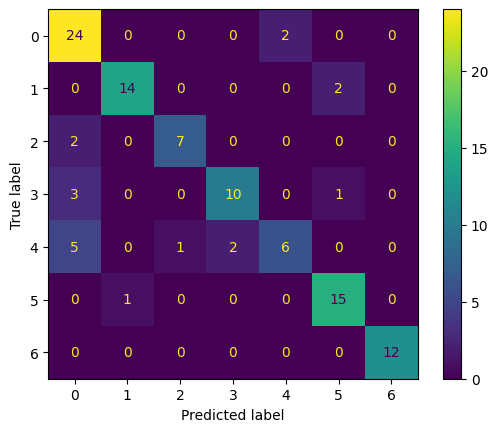


Hard cases for the model:

Label: disgust(2)
Hard cases of false negatives: ['anger(0)']

Label: fear(3)
Hard cases of false negatives: ['anger(0)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['anger(0)']



In [39]:
batch_size = 16
lstm_size = 32
num_epochs = 100
train_test_val = 'paper'
normalize = True

# load the data
X_train, X_test, X_val, y_train, y_test, y_val = load_data(data_path, train_test_val=train_test_val, normalize=normalize)

# train the model
train(X_train, y_train, X_val, y_val, num_epochs=num_epochs, patience=20, batch_size=batch_size, lstm_size=lstm_size, 
      model_spec='2D_CNN_LSTM/epochs{}_batch{}_LSTM{}_{}split_norm{}'.format(num_epochs, batch_size, lstm_size, 
                                                                             train_test_val, str(normalize)))

# evaluate model with keras
loss, metric = test(X_test, y_test, model_spec='2D_CNN_LSTM/epochs{}_batch{}_LSTM{}_{}split_norm{}'.format(num_epochs, 
                                                                                                           batch_size, 
                                                                                                           lstm_size, 
                                                                                                           train_test_val, 
                                                                                                           str(normalize)))

# add own evaluation 
model = load_model('../results/models/2D_CNN_LSTM/epochs{}_batch{}_LSTM{}_{}split_norm{}.h5'.format(num_epochs, 
                                                                                                    batch_size, 
                                                                                                    lstm_size, 
                                                                                                    train_test_val, 
                                                                                                    str(normalize)))
model_eval(model, X_train, X_test, y_train, y_test, confusion=True)

### 2) Normalized data, our split, LSTM 32, batch size 16 -> test F1 macro: 80.57%

There are 374 entries in the training data.
There are 81 entries in the testing data.
There are 80 entries in the validation data.
Epoch 1/100
24/24 - 25s - loss: 1.7654 - categorical_accuracy: 0.3128 - val_loss: 1.7748 - val_categorical_accuracy: 0.4125 - 25s/epoch - 1s/step
Epoch 2/100
24/24 - 18s - loss: 1.4754 - categorical_accuracy: 0.4893 - val_loss: 1.6479 - val_categorical_accuracy: 0.5125 - 18s/epoch - 755ms/step
Epoch 3/100
24/24 - 19s - loss: 1.2921 - categorical_accuracy: 0.5909 - val_loss: 1.6652 - val_categorical_accuracy: 0.3750 - 19s/epoch - 809ms/step
Epoch 4/100
24/24 - 21s - loss: 1.1476 - categorical_accuracy: 0.6257 - val_loss: 1.7343 - val_categorical_accuracy: 0.3000 - 21s/epoch - 876ms/step
Epoch 5/100
24/24 - 22s - loss: 0.9780 - categorical_accuracy: 0.7460 - val_loss: 1.7044 - val_categorical_accuracy: 0.2250 - 22s/epoch - 911ms/step
Epoch 6/100
24/24 - 22s - loss: 0.8808 - categorical_accuracy: 0.7754 - val_loss: 1.5580 - val_categorical_accuracy: 0.3000 - 2

Epoch 55/100
24/24 - 24s - loss: 0.0100 - categorical_accuracy: 1.0000 - val_loss: 0.3689 - val_categorical_accuracy: 0.9500 - 24s/epoch - 983ms/step
Epoch 56/100
24/24 - 24s - loss: 0.0098 - categorical_accuracy: 1.0000 - val_loss: 0.3759 - val_categorical_accuracy: 0.8875 - 24s/epoch - 991ms/step
Epoch 57/100
24/24 - 22s - loss: 0.0096 - categorical_accuracy: 1.0000 - val_loss: 0.3927 - val_categorical_accuracy: 0.8500 - 22s/epoch - 905ms/step
Epoch 58/100
24/24 - 23s - loss: 0.0094 - categorical_accuracy: 1.0000 - val_loss: 0.4603 - val_categorical_accuracy: 0.8625 - 23s/epoch - 961ms/step
Epoch 59/100
24/24 - 22s - loss: 0.0093 - categorical_accuracy: 1.0000 - val_loss: 0.3846 - val_categorical_accuracy: 0.8750 - 22s/epoch - 928ms/step
Epoch 60/100
24/24 - 22s - loss: 0.0111 - categorical_accuracy: 1.0000 - val_loss: 1.1602 - val_categorical_accuracy: 0.6250 - 22s/epoch - 929ms/step
Epoch 61/100
24/24 - 23s - loss: 0.0111 - categorical_accuracy: 1.0000 - val_loss: 0.5881 - val_cate

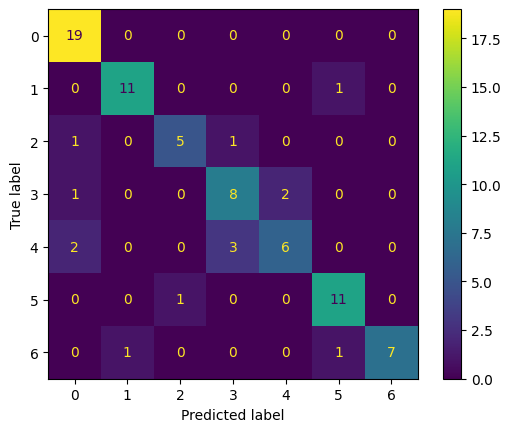


Hard cases for the model:

Label: fear(3)
Hard cases of false positives: ['happiness(4)']

Label: happiness(4)
Hard cases of false negatives: ['fear(3)']
Hard cases of false positives: ['fear(3)']



In [12]:
batch_size = 16
lstm_size = 32
num_epochs = 100
train_test_val = 'ours'
normalize = True

# load the data
X_train, X_test, X_val, y_train, y_test, y_val = load_data(data_path, train_test_val=train_test_val, normalize=normalize)

# train the model
train(X_train, y_train, X_val, y_val, num_epochs=num_epochs, patience=20, batch_size=batch_size, lstm_size=lstm_size, 
      model_spec='2D_CNN_LSTM/epochs{}_batch{}_LSTM{}_{}split_norm{}'.format(num_epochs, batch_size, lstm_size, 
                                                                             train_test_val, str(normalize)))

# evaluate model with keras
loss, metric = test(X_test, y_test, model_spec='2D_CNN_LSTM/epochs{}_batch{}_LSTM{}_{}split_norm{}'.format(num_epochs, 
                                                                                                           batch_size, 
                                                                                                           lstm_size, 
                                                                                                           train_test_val, 
                                                                                                           str(normalize)))

# add own evaluation 
model = load_model('../results/models/2D_CNN_LSTM/epochs{}_batch{}_LSTM{}_{}split_norm{}.h5'.format(num_epochs, 
                                                                                                    batch_size, 
                                                                                                    lstm_size, 
                                                                                                    train_test_val, 
                                                                                                    str(normalize)))
model_eval(model, X_train, X_test, y_train, y_test, confusion=True)